In [39]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

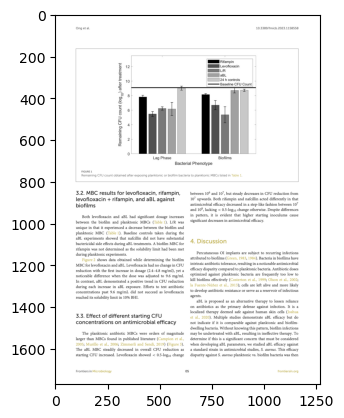

In [2]:
img_full = cv2.imread('./../../samples/imgPDF.png')
plt.imshow(img_full)

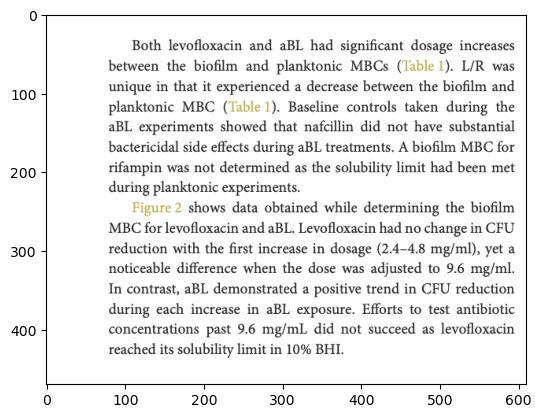

In [3]:
img = img_full[930:1400, 20:630]
plt.imshow(img)

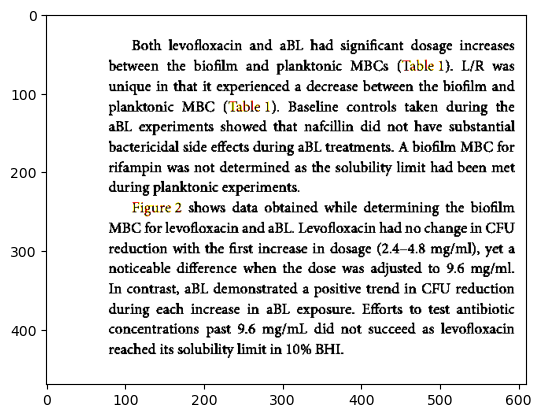

In [4]:
_,imgThresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
plt.imshow(imgThresh1,cmap='gray')

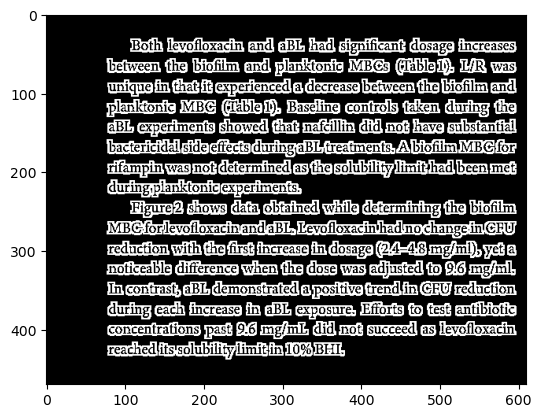

In [5]:
bs = 5
k = -0.2
maxval = 255
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgThresh2 = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                           type=cv2.THRESH_BINARY,blockSize=bs,k=k)
plt.imshow(imgThresh2,cmap='gray')

In [6]:
def preprocess(totalLabels,stats, centroids):
    #print(totalLabels,stats.shape,centroids.shape)
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    return df

In [7]:
def plot_components(df,comps=[]):
    output = img.copy() 
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(output)

In [8]:
totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh2,4,cv2.CV_32S)
comp_df = preprocess(totalLabels,stats, centroid)
comp_df.shape

(373, 9)

In [9]:
comp_df_filtered = comp_df[(comp_df['area'] > 50) & (comp_df['aspect_ratio'] > 1.8) & (comp_df['area'] < 3000)]
comp_df_filtered.shape

(96, 9)

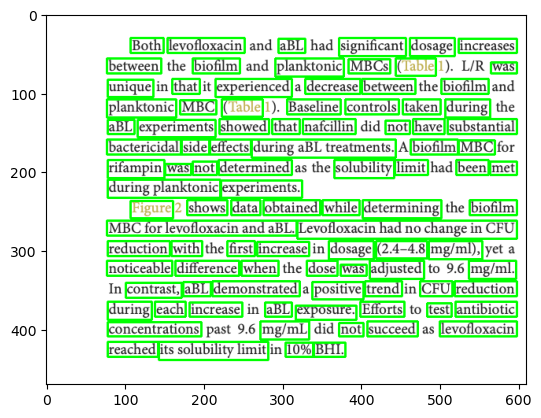

In [10]:
plot_components(comp_df_filtered,comps=comp_df_filtered.label_id.unique())

In [11]:
df = comp_df_filtered.copy()
df.shape

(96, 9)

In [ ]:
def find_distance(box,centroid):
    x0,y0 = centroid
    x,y,w,h = box[['left','top','width','height']]
    print(x0,y0,x,y,w,h)
    dis = 100
    if(x0 <= x):
        print(10)
        if(y0 <= y):
            print(11)
            dis = np.sqrt(((x-x0)*(x-x0)) + ((y-y0)*(y-y0)))
        elif (y0 >= y+h):
            print(12)
            dis = np.sqrt(((x-x0)*(x-x0)) +( (y+h-y0)*(y+h-y0)))
        else:
            print(13)
            dis = np.abs(x-x0)
    elif(x0 > x+w):
        print(20)
        if(y0 <= y):
            print(21)
            dis = np.sqrt(((x+w-x0)*(x+w-x0)) + ((y-y0)*(y-y0)))
        elif (y0 >= y+h):
            print(22)
            dis = np.sqrt(((x+w-x0)*(x+w-x0)) + ((y+h-y0)*(y+h-y0)))
        else:
            print(23)
            dis = np.abs(x+w-x0)
    else:
        print(30)
        if(y0 <= y):
            print(31)
            dis = np.abs(y0-y)
        elif (y0 >= y+h):
            print(32)
            dis = np.abs(y+h-y0)
    return dis

In [ ]:
center = (0.0,0.0)
box = (10,10,5,5)

In [ ]:
df = pd.DataFrame({
    'left':[-5.],
    'top':[5.],
    'width':[5],
    'height':[5]
})

In [ ]:
df

In [ ]:
df.apply(find_distance,centroid=(0,0),axis=1)

In [ ]:
df.apply(find_distance,centroid=(0,10),axis=1)

In [ ]:
df.apply(find_distance,centroid=(10,0),axis=1)

In [ ]:
df.apply(find_distance,centroid=(10,10),axis=1)

In [52]:
data = {
    'new_left' : [-6,-5,-4,-2,4,2,1],
    'new_top' : [-4,-1,4,-4,-4,-1,4],
    'new_width' : [2,3,2,5,3,5,3],
    'new_height' : [2,2,2,2,2,2,2]
}

test_df = pd.DataFrame(data)
test_df[['distance','intersection']] = test_df.apply(nearest_distance,axis=1)
test_df = test_df.sort_values(by='distance')
test_df

,new_left,new_top,new_width,new_height,distance,intersection
1,-5,-1,3,2,2.000000,"(-2, 0)"
3,-2,-4,5,2,2.000000,"(0, -2)"
5,2,-1,5,2,2.000000,"(2, 0)"
6,1,4,3,2,4.123106,"(1, 4)"
0,-6,-4,2,2,4.472136,"(-4, -2)"
2,-4,4,2,2,4.472136,"(-2, 4)"
4,4,-4,3,2,4.472136,"(4, -2)"


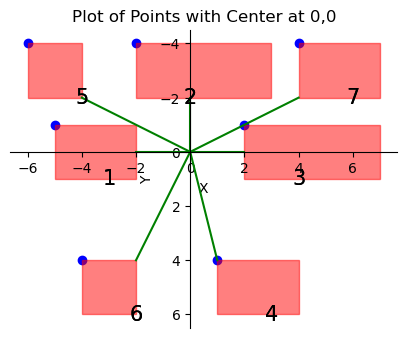

In [57]:
plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_aspect('equal')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()

for i in range(len(test_df)):
    # Plot the point
    plt.scatter(test_df.iloc[i]['new_left'], test_df.iloc[i]['new_top'], color='blue')

    # Add the rectangle
    rect = mpatches.Rectangle(xy=(test_df.iloc[i]['new_left'], test_df.iloc[i]['new_top']),
                             width=test_df.iloc[i]['new_width'],
                             height=test_df.iloc[i]['new_height'],
                             color='red',
                             alpha=0.5)

    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    center = np.array([0, 0])

    # Get the intersection coordinate
    intersection = test_df.iloc[i]['intersection']

    # Draw the line from the center to the intersection
    plt.plot([center[0], intersection[0]], [center[1], intersection[1]], color='green')
    
    text = plt.text(test_df.iloc[i]['new_left']+2, test_df.iloc[i]['new_top']+2, '{}'.format(i+1), ha='center', va='center', fontsize=15)
    ax.add_artist(text)


# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of Points with Center at 0,0')

# Show the plot
plt.show()


In [44]:
def nearest_distance(box):
    x,y,w,h = box[['new_left','new_top','new_width','new_height']]
    dis = 100
    intersect_point = (-100,-100)
    if(0 <= x):
        if(0 <= y):
            dis = np.sqrt((x*x) + (y*y))
            intersect_point = (x,y)
        elif (0 >= y+h):
            dis = np.sqrt((x*x) +((y+h)*(y+h)))
            intersect_point = (x,y+h)
        else:
            dis = np.abs(x)
            intersect_point = (x,0)
    elif(0 > x+w):
        if(0 <= y):
            dis = np.sqrt(((x+w)*(x+w)) + ((y)*(y)))
            intersect_point = (x+w,y)
        elif (0 >= y+h):
            dis = np.sqrt(((x+w)*(x+w)) + ((y+h)*(y+h)))
            intersect_point = (x+w,y+h)
        else:
            dis = np.abs(x+w)
            intersect_point = (x+w,0)
    else:
        if(0 <= y):
            dis = np.abs(y)
            intersect_point = (0,y)
        elif (0 >= y+h):
            dis = np.abs(y+h)
            intersect_point = (0,y+h)
        else:
            dis = 0
            intersect_point = (0,0)
    return pd.Series([dis, intersect_point])

In [13]:
def plot_nn_patch(df,img,root_label, neighbor_labels):
            
    output = img.copy()
    count = 0
    x,y,w,h = df[df['label_id'] == root_label][['left','top','width','height']].values[0]  
    print(df[df['label_id'] == root_label])
    cv2.rectangle(output, (x, y), (x + w, y + h),(255,0,0) , 2)
    for neighbor in neighbor_labels:
        count += 1
        x1,y1,w1,h1 = df[df['label_id'] == neighbor][['left','top','width','height']].values[0]
        cv2.rectangle(output, (x1, y1), (x1 + w1, y1 + h1),(0, 255,0) , 2)
        cv2.putText(output, str(count), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        #cv2.circle(output, (100, 100), 5, (255, 255, 255), -1)
    plt.imshow(output)

In [14]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id']:
        print("unknown component")
        return
    
    #extract word-coordinates
    x,y,w,h = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height']].values[0]

    #filter candidates
    c1 = (df['centroid_x'] >= x-w) & (df['centroid_x'] <= x+w)
    c2 = (df['centroid_y'] >= y-h) & (df['centroid_y'] <= y+h)
    temp_df = df[c1 & c2]
    window = 1
    while(temp_df.shape[0] < k+1):
        window += 0.2
        c1 = (df['centroid_x'] >= x-(window*w)) & (df['centroid_x'] <= x+(window*w))
        c2 = (df['centroid_y'] >= y-(window*h)) & (df['centroid_y'] <= y+(window*h))
        temp_df = df[c1 & c2]
    
    #drop curr word
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #transalation-invariance 
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)
    temp_df['new_centroid_y'] = (temp_df['centroid_y']-y)
    
    #rotation-invariance
    #should be reset to baseline during Image enhancement/preprop
    
    #scale-invariance
    temp_df['new_left'] = temp_df['left']/w
    temp_df['new_top'] = temp_df['top']/w
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/w
    
    #get metrics
    temp_df['distance'] = temp_df.apply(nearest_distance,axis=1)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    
    res_df = temp_df.sort_values(by='distance')[1:k+1]
    res_df = res_df.sort_values(by='theta')
    
    return res_df

In [16]:
df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio
1,2,107,30,42,19,388,128.515464,39.796392,2.21
2,3,154,30,98,19,937,201.500534,40.469584,5.16
4,5,295,31,34,18,329,311.088146,40.024316,1.89
6,7,372,30,85,23,892,413.839686,40.659193,3.70
7,8,462,30,57,23,538,490.334572,41.392193,2.48
...,...,...,...,...,...,...,...,...,...
341,342,372,392,31,17,293,388.204778,400.822526,1.82
359,360,78,416,64,19,646,110.178019,426.411765,3.37
360,361,143,416,139,23,1527,212.889980,425.972495,6.04
362,363,304,417,35,18,377,320.816976,425.424403,1.94


In [15]:
word = 85
df = comp_df_filtered.copy()
candidate_df = build_single_lexicon(word, df,k=5)
candidate_df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,new_centroid_x,new_centroid_y,new_left,new_top,new_width,new_height,distance,theta
85,86,453,108,48,19,479,475.087683,118.440501,2.53,60.469848,-0.287206,6.661765,5.684211,0.705882,1.000000,8.757246,0.000000
110,111,431,135,31,17,293,447.204778,143.822526,1.82,32.586944,25.094819,6.338235,7.105263,0.455882,0.894737,9.521449,37.599441
104,105,326,133,67,19,717,359.238494,142.748954,3.53,-55.379341,24.021247,4.794118,7.000000,0.985294,1.000000,8.484313,156.550812
83,84,306,108,68,19,675,339.696296,118.254815,3.58,-74.921538,-0.472892,4.500000,5.684211,1.000000,1.000000,7.249845,180.361637
57,58,401,82,68,19,674,432.735905,92.893175,3.58,18.118071,-25.834532,5.897059,4.315789,1.000000,1.000000,7.307622,305.042445


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
84        85   380  108     68      19   628  414.617834  118.727707   

    aspect_ratio  
84          3.58  


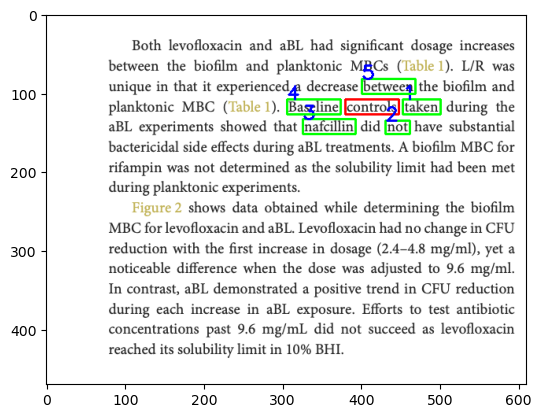

In [52]:
plot_nn_patch(df,img,word,candidate_df.label_id.unique())

In [1]:
df.sort_values(by=['area'])

NameError: name 'df' is not defined